In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles = open('data/1to6.dmu.safe', 'r').read().splitlines()
print(len(smiles))
print(max(len(w) for w in smiles))
print(smiles[:8])

35466
23
['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N']


In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['%'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '-', 5: '.', 6: '1', 7: '2', 8: '3', 9: '4', 10: '5', 11: '6', 12: '=', 13: 'C', 14: 'H', 15: 'N', 16: 'O', 17: '[', 18: ']', 19: 'c', 20: 'n', 21: 'o', 0: '%'}
22


In [8]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles)

In [9]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(smiles):
    X, Y = [], []
    
    for s in smiles:
        context = [0] * block_size
        for ch in s + '%':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
n1 = int(0.8 * len(smiles))
n2 = int(0.9 * len(smiles))
Xtr, Ytr = build_dataset(smiles[:n1])
Xdev, Ydev = build_dataset(smiles[n1:n2])
Xte, Yte = build_dataset(smiles[n2:])

torch.Size([322111, 8]) torch.Size([322111])
torch.Size([40337, 8]) torch.Size([40337])
torch.Size([40321, 8]) torch.Size([40321])


In [10]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

%%%%%%%% --> O
%%%%%%%O --> =
%%%%%%O= --> N
%%%%%O=N --> C
%%%%O=NC --> 1
%%%O=NC1 --> =
%%O=NC1= --> N
%O=NC1=N --> N
O=NC1=NN --> 1
=NC1=NN1 --> O
NC1=NN1O --> %
%%%%%%%% --> N
%%%%%%%N --> =
%%%%%%N= --> N
%%%%%N=N --> C
%%%%N=NC --> 1
%%%N=NC1 --> =
%%N=NC1= --> N
%N=NC1=N --> N
N=NC1=NN --> 1


In [11]:
# Create MLP and WaveNet models
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class makemoreWaveNet(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size * 2, num_hiddens, bias=False)
        self.fc2 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.fc3 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.bn1 = nn.BatchNorm1d(num_hiddens)
        self.bn2 = nn.BatchNorm1d(num_hiddens)
        self.bn3 = nn.BatchNorm1d(num_hiddens)
        self.tanh = nn.Tanh()
        self.fc_fin = nn.Linear(num_hiddens, vocab_size)
        
        

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0] * x.shape[1]//2, x.shape[2]*2)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.tanh(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh(x)
    
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.tanh(x)

        x = self.fc_fin(x)
        return x 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
n_embd = 10
n_hidden = 68
batch_size = 32

idx = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[idx], Ytr[idx]

model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
x = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([32, 22]) 22002


In [14]:
max_steps = 210000
ini_lr = 0.1
model = makemoreWaveNet(vocab_size, n_embd, n_hidden).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=ini_lr)

lossi = []

for i in range(max_steps):
    # Sample a batch of data
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx].to(device), Ytr[idx].to(device)
    
    # train the model
    model.train()
    optimizer.zero_grad()
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    # backprop
    loss.backward()
    optimizer.step()
    
    # Save checkpoint every 50,000 iterations
    modelName = 'Safe_WaveNet'
    if i % 50000 == 0 and i > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': i
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{i}.pt')
        print(f'Checkpoint saved at iteration {i}')
    
    if i > 150000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01

/home/hieu/miniconda3/envs/mlmat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      0/ 210000: 3.2756
  10000/ 210000: 1.0201
  20000/ 210000: 1.1676
  30000/ 210000: 1.0036
  40000/ 210000: 1.1451
  50000/ 210000: 0.9235
Checkpoint saved at iteration 50000
  60000/ 210000: 0.8518
  70000/ 210000: 1.2622
  80000/ 210000: 1.2597
  90000/ 210000: 0.8070
 100000/ 210000: 0.8781
Checkpoint saved at iteration 100000
 110000/ 210000: 0.8806
 120000/ 210000: 1.0089
 130000/ 210000: 1.2058
 140000/ 210000: 1.1252
 150000/ 210000: 1.2002
Checkpoint saved at iteration 150000
 160000/ 210000: 0.8234
 170000/ 210000: 1.1551
 180000/ 210000: 0.9902
 190000/ 210000: 1.2421
 200000/ 210000: 1.2436
Checkpoint saved at iteration 200000


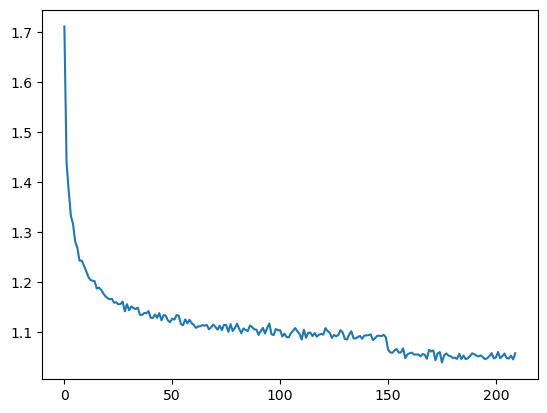

In [15]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [16]:
# Load the model from checkpoint
checkpoint = torch.load('models/Safe_WaveNet_checkpoint_200000.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on train and dev sets
model.to('cpu')
model.eval()
total_params = sum(p.numel() for p in model.parameters())   
print(f'{total_params:,} total parameters.')
with torch.no_grad():
    logits = model(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    print('train', loss.item())
    logits = model(Xdev)
    loss = F.cross_entropy(logits, Ydev)
    print('dev', loss.item())

22,002 total parameters.
train 1.0288925170898438
dev 1.0477410554885864


In [18]:
# sample from the model
checkpoint = torch.load('models/Safe_WaveNet_checkpoint_200000.pt')
block_size = 8
vocab_size = 22
n_embd = 10
n_hidden = 68
batch_size = 32
model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
genList = []
with torch.no_grad():
    for _ in range(10000):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        
        genList.append(''.join(itos[i] for i in out).replace('%','')) # decode and collect the generated smiles

In [19]:
genList

['N1C32C3C1C23',
 'NN1C2=CN1C2',
 'N=C=C(O)O1',
 'CN(N)N=CO',
 'N=C=NNON',
 'NN(N)C=C',
 'N=CN=CNO',
 'NN=NC1CC1',
 'OC1NC2=NC2N1',
 'N#CN(O)CN',
 'C=NCN1CO1',
 'CC1(N)CN1',
 'N1=COOCC1',
 'COOC1C=N1',
 'CCC#CC=C',
 'CC(=O)C(N)=O',
 'OC1CC2=CN12',
 'N=CC1NC=C1N',
 'NNNN1C#C1',
 'C1=CC=1C1CN1O',
 'C=CN2.C12N=N1',
 'NC1CNOO1',
 'C#CC1=CN=N1',
 'On1ncc1=2',
 'C=CNN(C)O',
 'On1c(=O)c1=O',
 'ON=C1C=C=C1',
 'c1c2c3c2c3-1',
 'C=C1C2NC12',
 'C=C=C1C=C1C',
 'N=C(O)C1=CN1',
 'CNN(O)C=O',
 'CC1C#COC1',
 'NCC1=C=N1',
 'c1c2c3cc2n12',
 'C1=3NONC12.O1C#C2',
 'C1=C2C3N4C1C342',
 'OC12OC13OC23',
 'OC1C=C=CO1',
 'OC1OC=ON1',
 'N#CN1C2NN21',
 'N#CCC(N)=O',
 'CN1OCN1',
 'N=NC12OC1N2N',
 'O=CN1OC1O',
 'CC1C2=CC21',
 'O=NNC1C=C1',
 'OCC=C',
 'CC1=NC12NC2',
 'NC1C=CC1O',
 'O=NN=C1CO1',
 'C1=CC12C1=C=O1.CN2',
 'C1CC2(CO2)O1',
 'OCN1C2CN21',
 'CC1C=C1OO',
 'CN1CON=N1',
 'C=CN=NNC',
 'N=NN1C=C=CN=C=NO',
 'O=NC1=C2CC2C=1',
 'C1=NC2OC2O1',
 'CC(=O)NO',
 'ON1OC1=C=N1',
 'N=CNON=O',
 'C=NCC1CC1',
 'O=NC1(O)NN1',
 

In [20]:
# Check for validity
from rdkit import Chem
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

validCount = 0
uniqueList = []
for s in genList:
    if Chem.MolFromSmiles(s):
        validCount += 1
        canonicalSmiles = Chem.MolToSmiles(Chem.MolFromSmiles(s))
        if canonicalSmiles not in uniqueList:
            uniqueList.append(canonicalSmiles) 
print(f"Valid SMILES: {validCount}/{len(genList)}")
print(f"Unique SMILES: {len(uniqueList)}/{validCount}")

Valid SMILES: 8421/10000
Unique SMILES: 7141/8421


In [21]:
import rdkit
print(rdkit.__version__)

2024.03.3


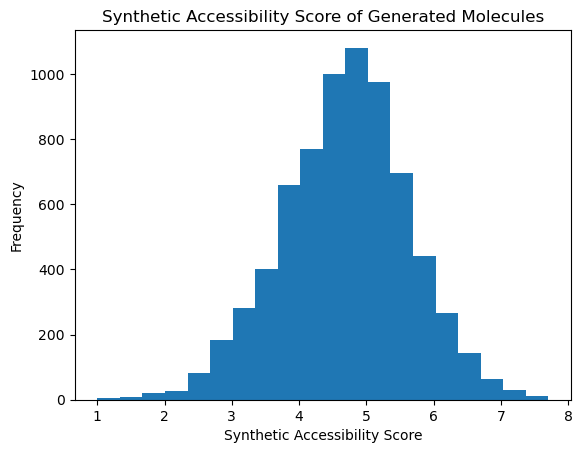

In [22]:
# Compute synthetic accessibility score 
import sys, os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()

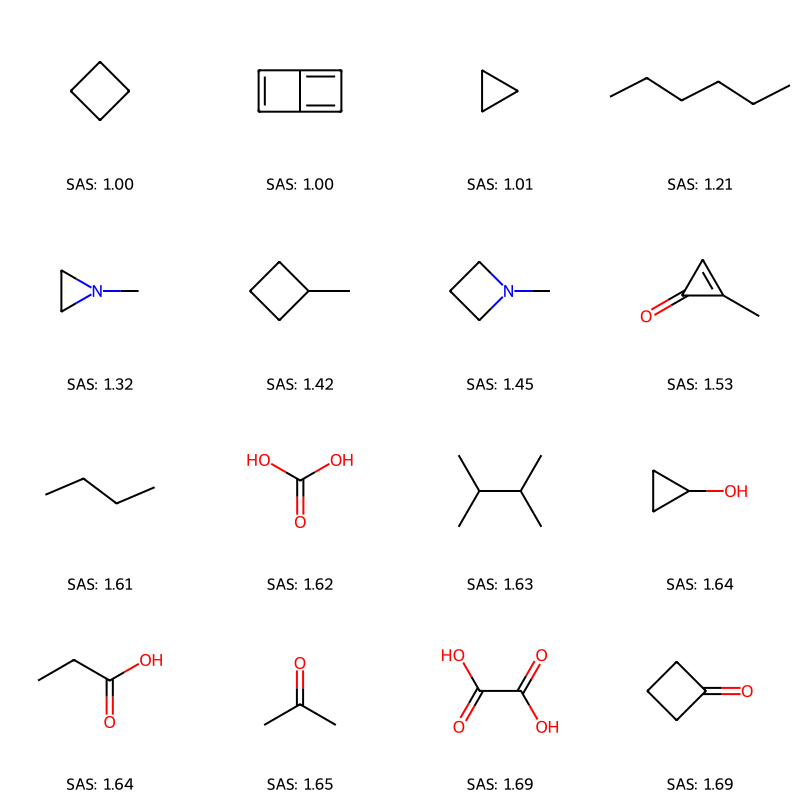

In [23]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

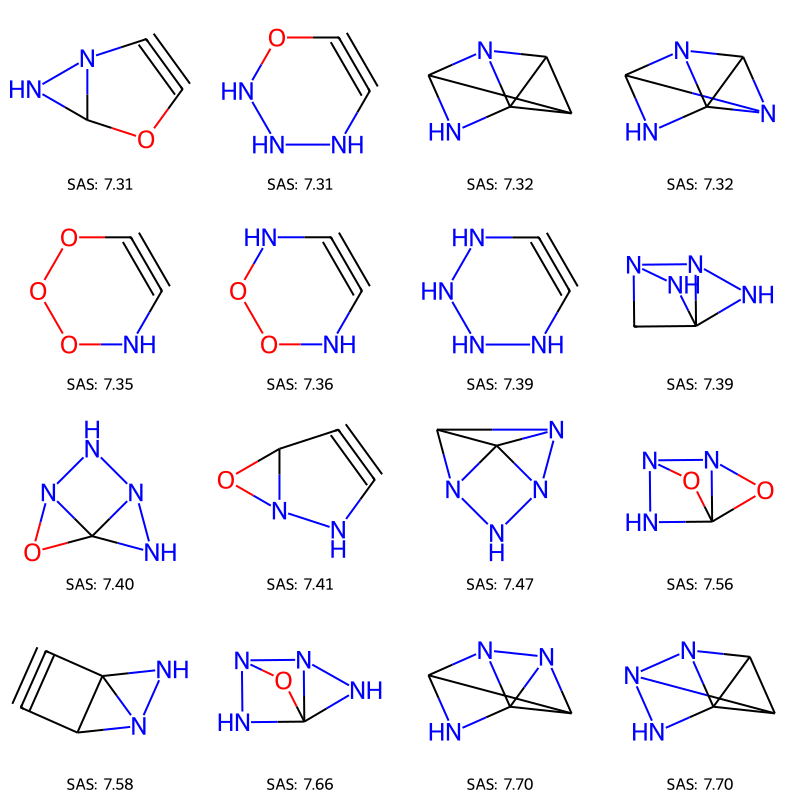

In [24]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])